<a href="https://colab.research.google.com/github/aaroncdvd/HRBS-CA_Python_AI/blob/main/PredictDiabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How can we use an ML model with the diabetes patient data?

![](https://miro.medium.com/max/2066/1*wWRGcsBwoXw-WNJi5UpoOw.png)

##Preparing your data!

*Create SQL Database*

![](https://hackr.io/blog/sql-cheat-sheet/thumbnail/large)

In [84]:
!apt-get install sqlite3 # Install SQLite

Reading package lists... Done
Building dependency tree       
Reading state information... Done
sqlite3 is already the newest version (3.22.0-1ubuntu0.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [85]:
![ -e diabetes.csv.db ] && rm diabetes.csv.db # Remove Existing SQL Files and Load New SQL From CSV
!wget -O - -o /dev/null 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'|sqlite3 -csv diabetes.csv.db ".import /dev/stdin diabetes_csv"

In [86]:
!sqlite3 diabetes.csv.db ".tables" # List SQL Tables (Like Excel 'Sheets')

diabetes_csv


*Query Diabetes.csv using SQL*

In [87]:
!sqlite3 -header -column diabetes.csv.db " \
select case when Outcome=0 then 'Not Diabetic' else 'Diabetic' end as Diagnosis,round(avg(BMI),0) AverageBMI,count(*) as Patients,round(avg(Glucose),0) AverageGlucose,round(avg(Age),0) AverageAge from diabetes_csv group by Outcome"

Diagnosis     AverageBMI  Patients    AverageGlucose  AverageAge
------------  ----------  ----------  --------------  ----------
Not Diabetic  30.0        500         110.0           31.0      
Diabetic      35.0        268         141.0           37.0      


##Exercise: Let's find Average BMI for patients with and without diabetes!

In [88]:
!sqlite3 -header -column diabetes.csv.db " \
select Outcome,avg(BMI) from diabetes_csv group by Outcome"

Outcome     avg(BMI)  
----------  ----------
0           30.3042   
1           35.1425373


*Make it Pretty!*

In [89]:
!sqlite3 -header -column diabetes.csv.db " \
select case when Outcome=0 then 'no diabetes' else 'diabetes' end as Outcome,avg(BMI) AveraveBMI from diabetes_csv group by Outcome"

Outcome      AveraveBMI
-----------  ----------
no diabetes  30.3042   
diabetes     35.1425373


*Save the results as a Virtual Table: Average_BMI*

In [90]:
!sqlite3 diabetes.csv.db "drop view if exists average_xyz; create view average_xyz as \
select case when Outcome=0 then 'no diabetes' else 'diabetes' end as Outcome,avg(BMI) AverageBMI, avg(age) AverageAge from diabetes_csv group by Outcome"

In [91]:
!sqlite3 diabetes.csv.db ".tables" # List SQL Tables (Like Excel 'Sheets')

average_xyz   diabetes_csv


In [92]:
!sqlite3 -header -column diabetes.csv.db " \
select * from average_xyz"

Outcome      AverageBMI  AverageAge
-----------  ----------  ----------
no diabetes  30.3042     31.19     
diabetes     35.1425373  37.0671641


*Query Virtual Table*

In [93]:
!sqlite3 -header -column diabetes.csv.db " \
select * from average_BMI"

Error: no such table: average_BMI


## Load Data to Python

*Import SQL to Pandas*

In [94]:
import pandas as pd # Import Pandas
import sqlite3 # Import SQL

In [95]:
sqlite = sqlite3.connect("diabetes.csv.db") # Connect to Diabetes

In [96]:
diabetes_df = pd.read_sql_query("select * from diabetes_csv",sqlite) # Load SQL to Pandas
diabetes_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.34,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [97]:
diabetesX=diabetes_df[diabetes_df.columns[:8]]

In [98]:
diabetesY=diabetes_df[diabetes_df.columns[8:]]

## [>](https://datascienceplus.com/machine-learning-for-diabetes-with-python/) Do Machine Learning!

*Split into Test and Training*

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(diabetesX), diabetesY, test_size=0.5, random_state=42)
X_train

array([[-1.14185152,  0.62924378,  0.77001375, ...,  0.05170968,
        -0.11741105, -0.95646168],
       [-0.54791859, -0.184482  , -0.26394125, ..., -0.15136112,
        -0.15365247, -1.04154944],
       [ 0.3429808 ,  0.28497518,  0.66661825, ...,  0.90206862,
         1.46211102,  0.31985461],
       ...,
       [ 1.82781311, -0.62264204,  0.87340925, ...,  1.72704372,
         2.00573238,  0.40494237],
       [-1.14185152,  0.62924378, -3.57259724, ...,  1.32090213,
        -0.8059981 , -0.36084741],
       [-1.14185152,  0.12848945,  1.39038675, ..., -1.20479085,
        -0.63385134, -1.04154944]])

*Predict Diabetes Using ML Model*

In [100]:
import sklearn
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.768
Test set score: 0.786


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*Plot Weight Matrix*

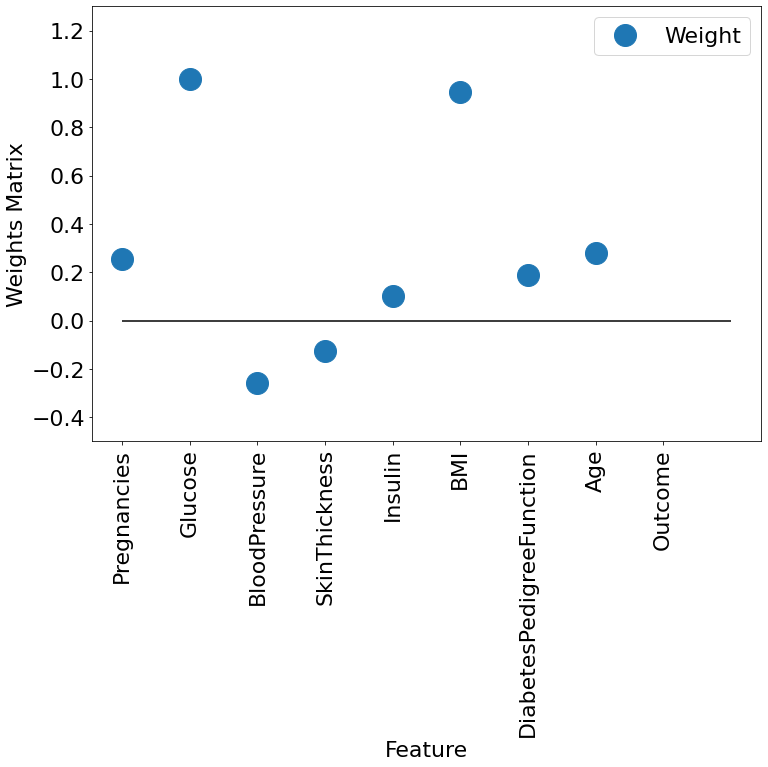

In [144]:
import matplotlib.pyplot as plt
diabetes_features = [x for i,x in enumerate(diabetes_df.columns)]
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(logreg.coef_.T, 'o', label="Weight", markersize=22)
plt.xticks(range(diabetes_df.shape[1]), diabetes_features, rotation=90)
plt.hlines(0, 0, diabetes_df.shape[1])
plt.ylim(-.5, 1.3)
plt.xlabel("Feature")
plt.ylabel("Weights Matrix")
plt.legend()

### How do we use this and what does it mean?

LARGER numbers mean MORE important to predict the Outcome! In this example, Glucose and BMI seem to be the MOST IMPORTANT to predict diabetes in patients!

## [>](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a) Confusion Matrix

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
predictions = logreg.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[216  38]
 [ 44  86]]


Text(0.5, 1.7999999999999972, 'Predicted label')

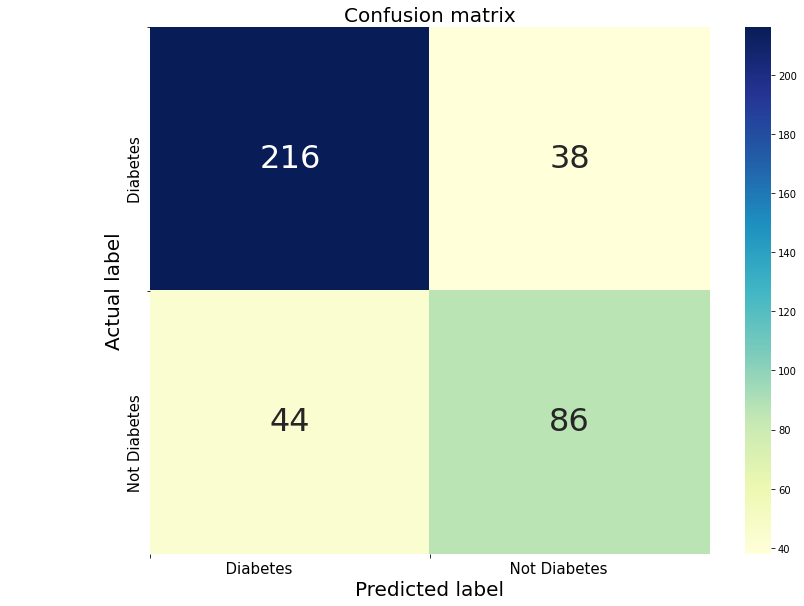

In [126]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g',annot_kws={"fontsize":32})

plt.tight_layout()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["                                              Diabetes", "                                                      Not Diabetes"], size = 15)
plt.yticks(tick_marks, ["Diabetes                        ", " Not Diabetes                       "], size = 15)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1, size = 20)
plt.ylabel('Actual label', size = 20)
plt.xlabel('Predicted label', size = 20)

## What's missing from our model?

The ML model has more information than just 'Diabetes' and 'Not Diabetes' but a number between 0 and 1! What could we use this for? Could we make a risk score using this as a percentage likelihood that the patient has diabetes rather than simply saying 'Diabetes' and 'Not Diabetes'?

## Save the Results

*Save Weights in SQL Database*

In [104]:
diabetes_ml = pd.DataFrame(logreg.coef_.T) # Export Weight Matrix
diabetes_ml.columns = ['weight'] # Change column name to 'weight' 

In [105]:
diabetes_ml["variable"] = pd.DataFrame(diabetes_features) # Include Column Names
diabetes_ml

,weight,variable
0,0.254279,Pregnancies
1,0.998293,Glucose
2,-0.258662,BloodPressure
3,-0.125226,SkinThickness
4,0.101080,Insulin
5,0.943905,BMI
6,0.186330,DiabetesPedigreeFunction
7,0.280974,Age


In [106]:
diabetes_ml.to_sql("diabetes_ml",sqlite, if_exists="replace") # Save Pandas Dataframe to SQL

In [107]:
!sqlite3 diabetes.csv.db ".tables" # List SQL Tables (Like Excel 'Sheets')

average_xyz   diabetes_csv  diabetes_ml 


*Make a Report of the Weights by Importance*

In [108]:
!sqlite3 -header -column diabetes.csv.db " \
select variable,round(weight,1) as weight from diabetes_ml order by abs(weight) desc"

variable    weight    
----------  ----------
Glucose     1.0       
BMI         0.9       
Age         0.3       
BloodPress  -0.3      
Pregnancie  0.3       
DiabetesPe  0.2       
SkinThickn  -0.1      
Insulin     0.1       


In [109]:
sqlite.close() # Disconnect from SQL